# Clustering (Unsupervised learning)

In [74]:
%matplotlib inline
import numpy as np
#%load_ext autoreload
#%autoreload 2
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn.apionly as sns

# K-mean clustering

Proximity (similarity) in the feature space, without worrying about labels

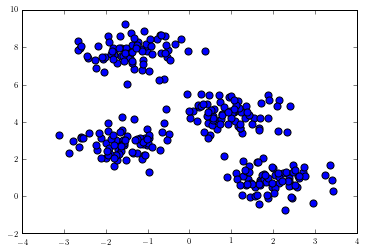

In [75]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

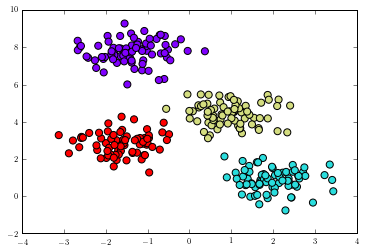

In [76]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

## The K-Means Algorithm: Expectation Maximization

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged

   A. Assign points to the nearest cluster center
   
   B. Set the cluster centers to the mean 


<img src="figures/kmean500.png" width="50%">

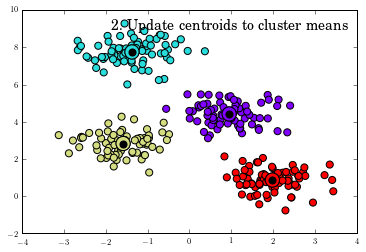

In [77]:
from fig_code import plot_kmeans_interactive
plot_kmeans_interactive();

Pros:

- simple

- always converges
    
Cons:

- similar size in each dimension (normalisation can fix this)

- sensitivite to initial centre guess (Monte Carlo can fix this)

- similar number of points in each group

- **sensitive to the choice of *k* (test several *k* and chose the one giving the best silhoutte score)**

- limitation to compact (roundish) convex blobs

- sensitive to noisy dimensions

## Silhouette score

measure of compactness of clusters

$s = \frac{b-a}{\max(a,b)}$

- $a$ are the mean distances between a sample and all other points in the same class
- $b$ the same with respect to the next nearest cluster

In [78]:
from sklearn import metrics
k_range = range(2,10)
silh_scores = []
for n_clusters in k_range:
    kmeans = KMeans(init='random', n_clusters=n_clusters, n_init=100)
    kmeans.fit(X)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    score = metrics.silhouette_score(X, labels, metric='sqeuclidean')
    silh_scores.append(score)
    print("%i Silhoutte score: %0.3f"%(n_clusters, score))

2 Silhoutte score: 0.699
3 Silhoutte score: 0.749
4 Silhoutte score: 0.869
5 Silhoutte score: 0.775
6 Silhoutte score: 0.673
7 Silhoutte score: 0.559
8 Silhoutte score: 0.472
9 Silhoutte score: 0.490


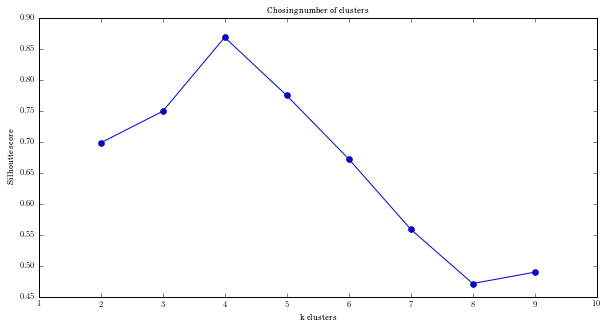

In [79]:
plt.figure(figsize=(10,5))
plt.plot(k_range,silh_scores,linestyle='-', marker='o')
plt.xlim((1,max(k_range)+1))
plt.xlabel('k clusters')
plt.ylabel('Silhoutte score')
plt.title('Chosing number of clusters');

In [80]:
from matplotlib import cm
def plot_silhouette_score(n_clusters, X):
    kmeans_silh = KMeans(init='random', n_clusters=n_clusters, n_init=100)
    kmeans_silh.fit(X)

    cluster_centers = kmeans_silh.cluster_centers_
    cluster_labels = kmeans_silh.labels_
    silhouette_avg = metrics.silhouette_score(X, cluster_labels, metric='sqeuclidean')

    print "%i clusters, avg silhouette score = %f"%(n_clusters, silhouette_avg)
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels,metric='sqeuclidean')

    y_lower = 0
    for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
    #    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 0  # 10 for the 0 samples

    plt.xlabel("The silhouette coef. values")
    #plt.ylabel("Cluster")

    plt.xlim((0, 1))

    # The vertical line for average silhoutte score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    #plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.title(("Silhouette (k = %d)" % n_clusters),
                fontsize=14, fontweight='bold')

2 clusters, avg silhouette score = 0.698630
3 clusters, avg silhouette score = 0.749395
4 clusters, avg silhouette score = 0.868727
5 clusters, avg silhouette score = 0.774925


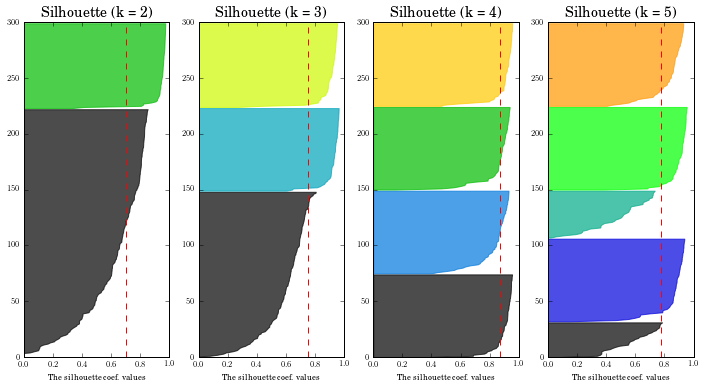

In [81]:
plt.figure(figsize=(12,6))
ns_clusters = [2,3,4,5]
for n_clusters in ns_clusters:
    plt.subplot(1,len(ns_clusters),n_clusters-1)
    plot_silhouette_score(n_clusters, X)

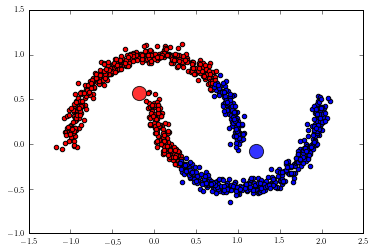

In [82]:
from sklearn.datasets import make_moons

[Xmoons, true_labels] = make_moons(n_samples=1000, noise=.05)
    
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(Xmoons)
labels = kmeans.labels_
kmeans_cluster_centers = kmeans.cluster_centers_

colors=['r', 'b']

for k, col in zip(range(2), colors):           
    my_members = labels == k
    plt.scatter(Xmoons[my_members, 0], Xmoons[my_members, 1],c=col, marker='o', s=20)     
    cluster_center = kmeans_cluster_centers[k]
    plt.scatter(cluster_center[0], cluster_center[1], marker = 'o', c=col, s=200, alpha=0.8)    



## Spectral clustering

Graph connectivity

1. Define affinity matrix: $A_{ij} \simeq \exp \left( -\alpha \parallel x_i - x_j \parallel^2 \right)$, alternatively $A_{ij} = 0$ if $\parallel x_i - x_j \parallel^2 \geq R$ hard cut off

2. Constuct Graph Laplacian: $L = D - A$, where $D$ is the diagonal degree matrix measuring number the degree at each node. Each cluster will be defined by a diagonal block.

3. solve eigenvalue problem $L v = \lambda v$

4. select k eigenvectors corresponging to the k lowest eigenvalues, to define k-dim subspace

5. form clusters in this subspace, using k-means

In [83]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=2,gamma=20., n_neighbors=10)
spectral.fit(Xmoons)
labels_moons = spectral.labels_

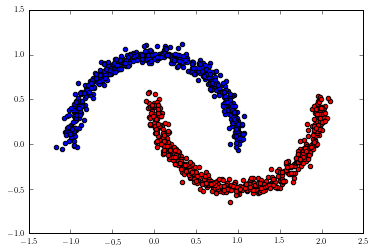

In [84]:
colors=['r', 'b']

for k, col in zip(range(2), colors):           
    my_members = labels_moons == k
    plt.scatter(Xmoons[my_members, 0], Xmoons[my_members, 1],c=col, marker='o', s=20)     

# Example: Minimum Spanning Tree

In [85]:
from scipy import sparse
from sklearn.mixture import GMM

from astroML.clustering import HierarchicalClustering, get_graph_segments
from astroML.datasets import fetch_great_wall

In [86]:
# get data
X = fetch_great_wall()

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

In [87]:
# Compute the MST clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10,
                               edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print " scale: %2g Mpc" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff)

n_components = model.n_components_
labels = model.labels_

 scale: 3.5495 Mpc


In [88]:
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

In [89]:
# Fit a GMM to each individual cluster
Nx = 100
Ny = 250
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T
density = np.zeros(Xgrid.shape[0])

for i in range(n_components):
    ind = (labels == i)
    Npts = ind.sum()
    Nclusters = min(12, Npts / 5)

    gmm = GMM(Nclusters).fit(X[ind])
    dens = np.exp(gmm.score(Xgrid))
    density += dens / dens.max()

density = density.reshape((Ny, Nx))

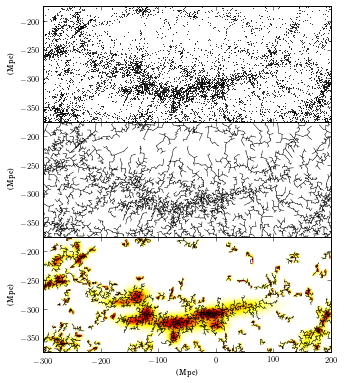

In [90]:
# Plot the results
fig = plt.figure(figsize=(5, 6))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(312, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=0.5)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(313, aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.5)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')

# Outliers (anomalies)

Objects that are different from most other objects

## Statistical outlier detection

- assumes data comes from normal distribution
- detects one outlier at time, remove the outlier and repeat
- $H_0$: there is no outlier

$G = \frac{max(X-\bar{X})}{\sigma}$

Reject $H_0$ if $G > \frac{N-1}{\sqrt(N)} \sqrt{ \frac{t^2_{\alpha/N, N-2} }{ N-2 + t^2_{\alpha/N, N-2} }}$

## Proximity based outlier detection

- outlier score: distance to k-th nearest neighbour
- sensitive to k
- a small cluster becomes an outlier

## Cluster-based outlier detection

- outlier score relative distance to cluster centre:

$\dfrac{distance(x, centroid_C)}{ median \left( \forall _{x’ \in C} distance(x’, centroid_C) \right) }$